##  Processors and Utils

Description of the main tools and utilities that one needs to prepare the data for the `WideDeep` model constructor. 

#### The `preprocessing`  module

There are 4 preprocessors, corresponding to 4 main components of the `WideDeep` model. These are

* `WidePreprocessor`
* `DeepPreprocessor`
* `TextPreprocessor`
* `ImagePreprocessor` 

Behind the scenes, these preprocessors use a series of helper funcions and classes that are in the `utils` module.

#### The `utils` module

Initially I did not intend to "expose" them to the user, but I believe can be useful for all sorts of preprocessing tasks, so let me discuss them briefly. 

The util tools in the module are: 

* `deep_utils.label_encoder`
* `text_utils.simple_preprocess`
* `text_utils.get_texts`
* `text_utils.pad_sequences`
* `text_utils.build_embeddings_matrix`
* `fastai_transforms.Tokenizer`
* `fastai_transforms.Vocab`
* `image_utils.SimplePreprocessor`
* `image_utils.AspectAwarePreprocessor`

They are accessible directly from `utils` (e.g. `wd.utils.label_encoder`). 

Let's have a look to what they do and how they might be useful to the user in general.

##  1. WidePreprocessor

This class simply takes a dataset and one-hot encodes it, with a few additional rings and bells. 

For example

In [1]:
import numpy as np
import pandas as pd
import pytorch_widedeep as wd

from pytorch_widedeep.preprocessing import WidePreprocessor

In [7]:
# have a look to the documentation
?WidePreprocessor

In [2]:
df = pd.read_csv("data/adult/adult.csv.zip")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
wide_cols = ['education', 'relationship','workclass','occupation','native-country','gender']
crossed_cols = [('education', 'occupation'), ('native-country', 'occupation')]

In [4]:
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = wide_preprocessor.fit_transform(df)
# From here on, any new observation can be prepared by simply running `.transform`
# new_X_wide = wide_preprocessor.transform(new_df)

In [5]:
X_wide

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

If you had a look to the documentation you will see that there is an option to return a sparse matrix. This will save memory on disk, but due to the batch generation process for `WideDeep` the running time will be notably slow. See [here](https://github.com/jrzaurin/pytorch-widedeep/blob/bfbe6e5d2309857db0dcc5cf3282dfa60504aa52/pytorch_widedeep/models/_wd_dataset.py#L47) for more details.

##  2. DeepPreprocessor

Label encodes the categorical columns and normalises the numerical ones (unless otherwised specified).

In [6]:
from pytorch_widedeep.preprocessing import DeepPreprocessor

In [8]:
?DeepPreprocessor

In [7]:
# cat_embed_cols = [(column_name, embed_dim), ...]
cat_embed_cols = [('education',10), ('relationship',8), ('workclass',10), ('occupation',10),('native-country',10)]
continuous_cols = ["age","hours-per-week"]

In [8]:
deep_preprocessor = DeepPreprocessor(embed_cols=cat_embed_cols, continuous_cols=continuous_cols)
X_deep = deep_preprocessor.fit_transform(df)
# From here on, any new observation can be prepared by simply running `.transform`
# new_X_deep = deep_preprocessor.transform(new_df)

In [9]:
X_deep

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.99512893, -0.03408696],
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
        -0.04694151,  0.77292975],
       [ 2.        ,  1.        ,  1.        , ...,  0.        ,
        -0.77631645, -0.03408696],
       ...,
       [ 1.        ,  3.        ,  0.        , ...,  0.        ,
         1.41180837, -0.03408696],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -1.21394141, -1.64812038],
       [ 1.        ,  4.        ,  6.        , ...,  0.        ,
         0.97418341, -0.03408696]])

Behing the scenes, `DeepProcessor` uses `label_encoder`, simply a numerical encoder for categorical featurers.

#### 2.1. `dense_utils`

You can access to `label_encoder` from utils

In [10]:
import pytorch_widedeep as wd

In [11]:
enc_df, enc_dict = wd.utils.label_encoder(df)

In [12]:
enc_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,0,226802,0,7,0,0,0,0,0,0,0,40,0,0
1,38,0,89814,1,9,1,1,1,1,0,0,0,50,0,0
2,28,1,336951,2,12,1,2,1,1,0,0,0,40,0,1
3,44,0,160323,3,10,1,0,1,0,0,7688,0,40,0,1
4,18,2,103497,3,10,0,3,0,1,1,0,0,30,0,0


In [13]:
enc_dict

{'workclass': {'Private': 0,
  'Local-gov': 1,
  '?': 2,
  'Self-emp-not-inc': 3,
  'Federal-gov': 4,
  'State-gov': 5,
  'Self-emp-inc': 6,
  'Without-pay': 7,
  'Never-worked': 8},
 'education': {'11th': 0,
  'HS-grad': 1,
  'Assoc-acdm': 2,
  'Some-college': 3,
  '10th': 4,
  'Prof-school': 5,
  '7th-8th': 6,
  'Bachelors': 7,
  'Masters': 8,
  'Doctorate': 9,
  '5th-6th': 10,
  'Assoc-voc': 11,
  '9th': 12,
  '12th': 13,
  '1st-4th': 14,
  'Preschool': 15},
 'marital-status': {'Never-married': 0,
  'Married-civ-spouse': 1,
  'Widowed': 2,
  'Divorced': 3,
  'Separated': 4,
  'Married-spouse-absent': 5,
  'Married-AF-spouse': 6},
 'occupation': {'Machine-op-inspct': 0,
  'Farming-fishing': 1,
  'Protective-serv': 2,
  '?': 3,
  'Other-service': 4,
  'Prof-specialty': 5,
  'Craft-repair': 6,
  'Adm-clerical': 7,
  'Exec-managerial': 8,
  'Tech-support': 9,
  'Sales': 10,
  'Priv-house-serv': 11,
  'Transport-moving': 12,
  'Handlers-cleaners': 13,
  'Armed-Forces': 14},
 'relationshi

##  3. TextPreprocessor

This preprocessor returns the tokenised, padded sequences that will be directly fed to the stack of LSTMs.

In [14]:
from pytorch_widedeep.preprocessing import TextPreprocessor

In [15]:
?TextPreprocessor

In [16]:
df=pd.read_csv("data/airbnb/airbnb_sample.csv")

In [17]:
texts = df.description.tolist()
texts[:2]

["My bright double bedroom with a large window has a relaxed feeling! It comfortably fits one or two and is centrally located just two blocks from Finsbury Park. Enjoy great restaurants in the area and easy access to easy transport tubes, trains and buses. Babies and children of all ages are welcome. Hello Everyone, I'm offering my lovely double bedroom in Finsbury Park area (zone 2) for let in a shared apartment.  You will share the apartment with me and it is fully furnished with a self catering kitchen. Two people can easily sleep well as the room has a queen size bed. I also have a travel cot for a baby for guest with small children.  I will require a deposit up front as a security gesture on both our parts and will be given back to you when you return the keys.  I trust anyone who will be responding to this add would treat my home with care and respect .  Best Wishes  Alina Guest will have access to the self catering kitchen and bathroom. There is the flat is equipped wifi interne

In [18]:
text_preprocessor = TextPreprocessor(text_col='description')
X_text = text_preprocessor.fit_transform(df)
# From here on, any new observation can be prepared by simply running `.transform`
# new_X_text = text_preprocessor.transform(new_df)

The vocabulary contains 6400 tokens


In [19]:
print(X_text[0])

[  29   48   37  367  818   17  910   17  177   15  122  349   53  879
 1174  126  393   40  911    0   23  228   71  819    9   53   55 1380
  225   11   18  308   18 1564   10  755    0  942  239   53   55    0
   11   36 1013  277 1974   70   62   15 1475    9  943    5  251    5
    0    5    0    5  177   53   37   75   11   10  294  726   32    9
   42    5   25   12   10   22   12  136  100  145]


`TextPreprocessor` uses the utilities within the `text_utils` and `fastai_utils` modules. Again, utilities there are directly accessible from `utils`. 

#### 3.1. `text_utils` and `fastai_utils`

`text_utils` are: `simple_preprocess`, `get_texts`, `pad_sequences`, `build_embeddings_matrix`

`fastai_utils` is the fastai's [transforms](https://github.com/fastai/fastai/blob/master/fastai/text/transform.py) module (with some minor adaptations to function outside the fastai library). Therefore, **all credit to Jeremy Howard and his team**. The reason for using fastai's `transforms` module instead of using directly the library is simply because the library is gigantic, and has a large number of dependencies. I wanted to keep this package as light as possible, and the only functions/classes I need are in that module. 

All utilities within that module are available in `pytorch-widedeep` via the `utils` module, so make sure you have a look because some functions there are quite handy. Here I will only focus on two: `Tokenizer` and `Vocab`. 

Let's have a look to some of these utils

In [20]:
tokens = wd.utils.get_texts(texts)
vocab = wd.utils.Vocab.create(tokens, max_vocab=2000, min_freq=1)

In [21]:
vocab.stoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxeos': 3,
             'xxfld': 4,
             'xxmaj': 5,
             'xxup': 6,
             'xxrep': 7,
             'xxwrep': 8,
             'and': 9,
             'the': 10,
             'to': 11,
             'is': 12,
             'in': 13,
             'of': 14,
             'with': 15,
             'london': 16,
             'for': 17,
             'you': 18,
             'room': 19,
             'are': 20,
             'from': 21,
             'flat': 22,
             'on': 23,
             'bedroom': 24,
             'there': 25,
             'it': 26,
             'walk': 27,
             'double': 28,
             'bed': 29,
             'house': 30,
             'has': 31,
             'kitchen': 32,
             'minutes': 33,
             'apartment': 34,
             'all': 35,
             'this': 36,
             'have': 37,
             'very': 38,
         

In [22]:
sequences = [vocab.numericalize(t) for t in tokens]
padded_seq = [wd.utils.pad_sequences(s, maxlen=200, pad_idx=1) for s in sequences]

In [23]:
padded_seq[0]

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    5,   70,  104,   28,   24,   15,   46,  450,   31,
        600, 1173,    5,   26,  508, 1299,   56,   41,   54,    9,   12,
        463,   69,   64,   54, 1474,   21,    5,  714,    5,   57,    5,
        200,   67,   61,   13,   10,   44,    9,  109,   75,   11,  109,
         94,  817,  400,    9,  164,    5, 1973,    9,  349,   14,   35,
          0,   20,  140,    5,  794,    5,  909,  646,   70,   77,   28,
         24,   13,    5,  714,    5,   57,   44,  163,   17,  392,   13,
        146,   34,    5,   18,   53,  293,   10,   34,   15,  247,    9,
         26,   12,  110,  171,   15,  294,  726,   32,    5,   54,  124,
         47,  583,  295,   79,   40,   10,   19,   31,  509,  191,   29,
         48,   37,  367,  818,   17,  910,   17,  177,   15,  122,  349,
         53,  879, 1174,  126,  393,   40,  911,    0,   23,  228,   71,
        819,    9,   53,   55, 1380,  225,   11,   

## 4. ImagePreprocessor

`ImagePreprocessor` simply resizes the images, being aware of the aspect ratio.  

In [24]:
image_preprocessor = wd.preprocessing.ImagePreprocessor(img_col='id', img_path="data/airbnb/property_picture/")
X_images = image_preprocessor.fit_transform(df)
# From here on, any new observation can be prepared by simply running `.transform`
# new_X_images = image_preprocessor.transform(new_df)

Reading Images from data/airbnb/property_picture/


  4%|▍         | 40/1001 [00:00<00:02, 391.71it/s]

Resizing


100%|██████████| 1001/1001 [00:02<00:00, 415.12it/s]


Computing normalisation metrics


In [25]:
X_images[0].shape

(224, 224, 3)

`ImagePreprocessor` uses two helpers: `SimplePreprocessor` and `AspectAwarePreprocessor`

These two classes are directly taken from Adrian Rosebrock's fantastic book ["Deep Learning for Computer Vision"](https://www.pyimagesearch.com/deep-learning-computer-vision-python-book/). Therefore, **all credit to Adrian**.

Let's see what they do

In [26]:
import cv2
from os import listdir
from random import sample

prop_img_path = "data/airbnb/property_picture/"
prop_imgnames = listdir(prop_img_path)
prop_imgnames = sample(prop_imgnames, 10)
print(prop_imgnames)

['512853.jpg', '460396.jpg', '92352.jpg', '472203.jpg', '534665.jpg', '529070.jpg', '549281.jpg', '499163.jpg', '218915.jpg', '526627.jpg']


In [27]:
prop_imgs = [cv2.imread(str(prop_img_path+img)) for img in prop_imgnames]
prop_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in prop_imgs]

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_img(im, figsize=(5,5), ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_axis_off()
    return ax

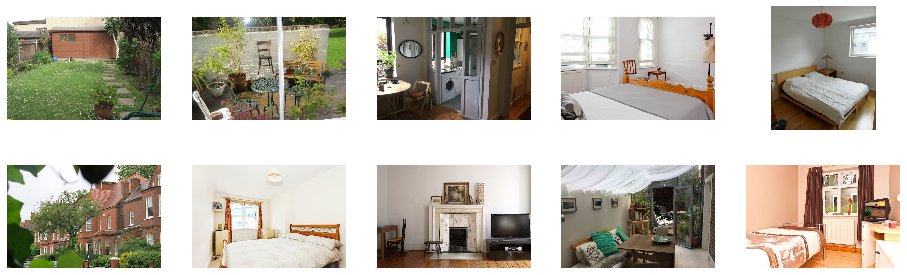

In [29]:
fig,axes = plt.subplots(2, 5, figsize=(16,5))
for i,im in enumerate(prop_imgs):
    show_img(im, ax=axes.flat[i])

In [30]:
print([im.shape for im in prop_imgs])

[(426, 639, 3), (426, 639, 3), (426, 639, 3), (426, 639, 3), (426, 360, 3), (426, 639, 3), (426, 639, 3), (426, 639, 3), (426, 639, 3), (426, 639, 3)]


In [31]:
spp = wd.utils.SimplePreprocessor(224,224)
prop_resized_imgs = [spp.preprocess(im) for im in prop_imgs]

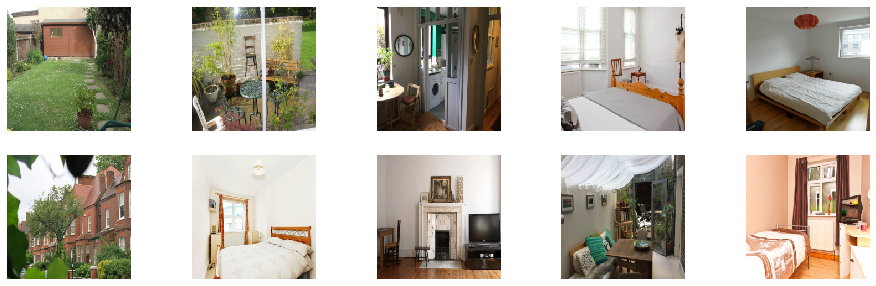

In [32]:
fig,axes = plt.subplots(2, 5, figsize=(16,5))
for i,im in enumerate(prop_resized_imgs):
    show_img(im, ax=axes.flat[i])

In [33]:
print([im.shape for im in prop_resized_imgs])

[(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)]


In [34]:
aap = wd.utils.AspectAwarePreprocessor(width=224, height=224)
prop_aap_resized_imgs = [aap.preprocess(im) for im in prop_imgs]

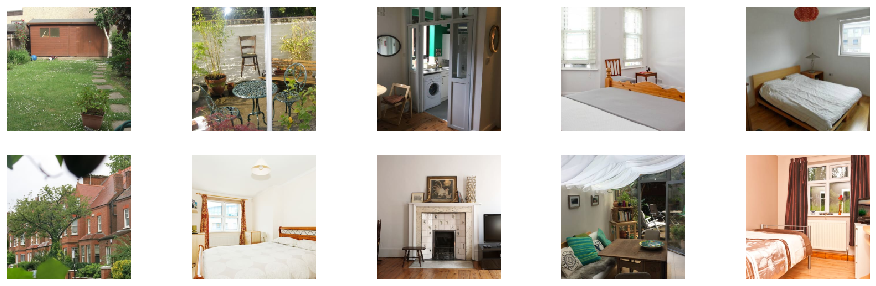

In [35]:
fig,axes = plt.subplots(2, 5, figsize=(16,5))
for i,im in enumerate(prop_aap_resized_imgs):
    show_img(im, ax=axes.flat[i])

In [36]:
print([im.shape for im in prop_aap_resized_imgs])

[(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)]
